In [1]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split

import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from torchmetrics import Accuracy
from torchmetrics.functional import accuracy, confusion_matrix, f1

import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

import seaborn as sns

## Read the data & separate features and labels

In [2]:
df = pd.read_csv("Data_removed_outlier_iqr.csv")

In [3]:
df.head(10)

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,35280,717.703,264.995250,170.035245,1.558472,0.766994,35772,211.943132,0.703616,0.986246,0.860694,0.799800,0.007511,0.001896,0.639680,0.996923,DERMASON
1,83296,1142.638,446.765889,239.013317,1.869209,0.844861,84270,325.662035,0.702588,0.988442,0.801709,0.728932,0.005364,0.000934,0.531342,0.993190,CALI
2,35594,689.634,254.572928,178.441837,1.426644,0.713214,35966,212.884213,0.811629,0.989657,0.940479,0.836241,0.007152,0.002157,0.699298,0.997650,DERMASON
3,52710,872.700,326.039383,207.399450,1.572036,0.771592,53280,259.060720,0.677419,0.989302,0.869707,0.794569,0.006186,0.001521,0.631340,0.992488,SIRA
4,62855,1004.759,413.879306,194.299306,2.130112,0.882954,63781,282.894807,0.598340,0.985482,0.782395,0.683520,0.006585,0.000887,0.467200,0.995188,HOROZ
5,36112,723.077,225.328776,204.666339,1.100957,0.418317,36709,214.427672,0.792243,0.983737,0.867945,0.951621,0.006240,0.003156,0.905583,0.997008,SEKER
6,59442,975.979,402.887444,190.149460,2.118794,0.881616,60289,275.107079,0.732468,0.985951,0.784192,0.682839,0.006778,0.000909,0.466268,0.987927,HOROZ
7,58931,957.164,388.354344,194.043039,2.001383,0.866225,59526,273.922032,0.822714,0.990004,0.808316,0.705340,0.006590,0.001006,0.497505,0.995698,HOROZ
8,34010,681.989,257.829640,168.646392,1.528818,0.756408,34410,208.093433,0.713147,0.988375,0.918886,0.807097,0.007581,0.001984,0.651405,0.995880,DERMASON
9,27280,603.203,223.021086,156.155434,1.428199,0.713964,27550,186.370531,0.760418,0.990200,0.942166,0.835663,0.008175,0.002459,0.698333,0.997359,DERMASON


In [4]:
X = df.drop(columns=["Class"]).values
y = df.Class.astype("category").cat.codes.values

## Creating the Neural Network

We can create a network separately or since this is a simple network so we can just simply put it inside our `LightningModule`

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(16, 256),
            nn.LeakyReLU(inplace=True),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 7),
            nn.SELU(inplace=True),
        )

    def forward(self, x):
        return self.net(x)

## Creating the `LightningDataModule`

In [20]:
class DrybeanDataModule(pl.LightningDataModule):
    def __init__(self, X, y, sampler=None):
        super(DrybeanDataModule, self).__init__()
        self.X, self.y = X, y
        self.sampler = sampler

    def prepare_data(self):
        if self.sampler is not None:
            self.X, self.y = self.sampler().fit_resample(self.X, self.y)

        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(self.X)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X_scaled, self.y, test_size=0.25
        )

    def setup(self, stage):
        if stage == "fit" or stage is None:
            X_train_tensor = torch.tensor(self.X_train, dtype=torch.float)
            y_train_tensor = torch.tensor(self.y_train, dtype=torch.long)
            ds = TensorDataset(X_train_tensor, y_train_tensor)

            lengths = [int(len(ds) * 0.8), int(len(ds) * 0.2) + 1]
            self.train_ds, self.val_ds = random_split(ds, lengths)

        if stage == "test" or stage is None:
            X_test_tensor = torch.tensor(self.X_test, dtype=torch.float)
            y_test_tensor = torch.tensor(self.y_test, dtype=torch.long)
            self.test_ds = TensorDataset(X_test_tensor, y_test_tensor)

    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=16, num_workers=4)

    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=16, num_workers=4)

    def test_dataloader(self):
        return DataLoader(self.test_ds, batch_size=16, num_workers=4)

## Creating the `LightningModule`

In [21]:
class LitDrybean(pl.LightningModule):
    def __init__(self):
        super(LitDrybean, self).__init__()
        self.model = Net()
        self.loss = nn.CrossEntropyLoss()

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=1e-4)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        feats, labels = batch

        preds = self.forward(feats)

        loss = self.loss(input=preds, target=labels)

        self.log("train_loss", loss)
        self.log("train_acc", accuracy(preds, labels), prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        feats, labels = batch

        preds = self.forward(feats)

        loss = self.loss(input=preds, target=labels)

        self.log("val_loss", loss)
        self.log("val_acc", accuracy(preds, labels), prog_bar=True)

        return loss

    def test_step(self, batch, batch_idx):
        feats, labels = batch

        preds = self.forward(feats)

        loss = self.loss(input=preds, target=labels)

        self.log("test_loss", loss)
        self.log("test_acc", accuracy(preds, labels), prog_bar=True)

        return loss

In [28]:
model = LitDrybean()
dm = DrybeanDataModule(X, y)
wandb_logger = WandbLogger(name="Adam-256-0.0001-bs16", project="pytorchlightning")
trainer = pl.Trainer(
    logger=wandb_logger, checkpoint_callback=True, min_epochs=5, max_epochs=10, log_every_n_steps=10, gpus=1
)

trainer.fit(model, datamodule=dm)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | model | Net              | 38.2 K
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
38.2 K    Trainable params
0         Non-trainable params
38.2 K    Total params
0.153     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [29]:
results = trainer.test()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.9185478687286377, 'test_loss': 0.23230046033859253}
--------------------------------------------------------------------------------


## Tracking using `Tensorboard`

In [30]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [31]:
# %tensorboard --logdir lightning_logs/version_

## Confusion Matrix with visualization for test predictions

In [32]:
with torch.no_grad():
    test_tensor = torch.tensor(dm.X_test)
    labels = torch.tensor(dm.y_test)
    preds = model.model(test_tensor.float())
    cf = confusion_matrix(preds, labels, num_classes=7)

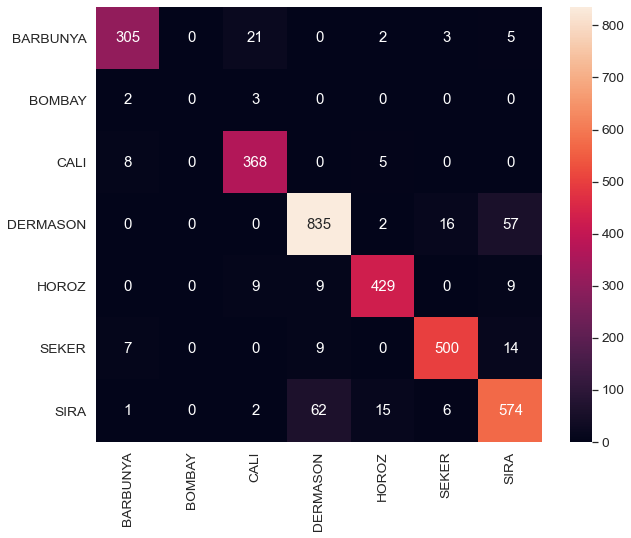

In [33]:
classes = df.Class.astype("category").cat.categories.tolist()
sns.set(rc={"figure.figsize": (10, 8)}, font_scale=1.25)
_ = sns.heatmap(cf, annot=True, xticklabels=classes, yticklabels=classes, fmt="d")